We have made pyanno compatible with python 3. To install it on your own computer, run "pip3 install pyanno3" in your command shell. 
See the [installation guide](http://docs.enthought.com/uchicago-pyanno/installation.html) for installing it on python 2.7.

In [81]:
import numpy as np
import scipy as sp
import pyanno
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB
import matplotlib.pyplot as plt
import seaborn as sns

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data).

In [3]:
x = np.loadtxt("data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ..., 
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [6]:
anno.missing_values

[-1]

# Annotation Statistics

Compute Cohen's kappa statistics, which measures the extent of agreement between two annotators. Here, Cohen's kappa statistics for the first two annotators are computed.

In [7]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

Get the pairwise measure matrix.

In [8]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print (m)

[[ 1.          0.43917037  0.47677621         nan         nan         nan
   0.45819119  0.43381462]
 [ 0.43917037  1.          0.38432922  0.41344423         nan         nan
          nan  0.33643611]
 [ 0.47677621  0.38432922  1.          0.39583333  0.51704894         nan
          nan         nan]
 [        nan  0.41344423  0.39583333  1.          0.34597068  0.4446844
          nan         nan]
 [        nan         nan  0.51704894  0.34597068  1.          0.37938644
   0.43039733         nan]
 [        nan         nan         nan  0.4446844   0.37938644  1.
   0.38341929  0.31214748]
 [ 0.45819119         nan         nan         nan  0.43039733  0.38341929
   1.          0.394806  ]
 [ 0.43381462  0.33643611         nan         nan         nan  0.31214748
   0.394806    1.        ]]


A heatmap visualization:

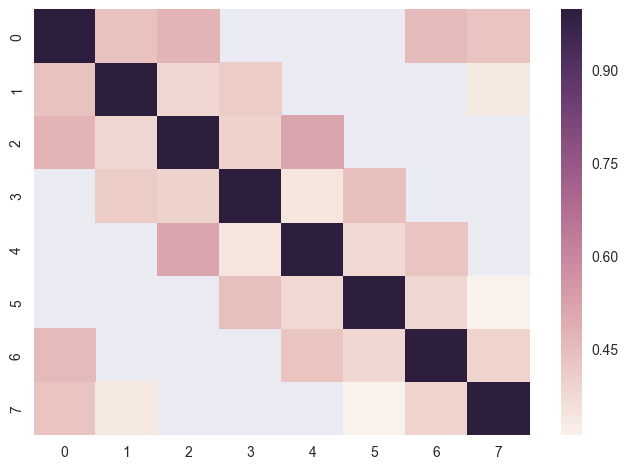

In [11]:
ax = sns.heatmap(m)
plt.show()

# Models

Now we use Rzhetsky et al (2009)'s models to make inference about true label classes. Pyanno provides four available models: ModelA, ModelB, ModelBt, and ModelBtLoopDesign. They should give similar results. To estimate the parameters for any models, we first need to create a new model. 

In [14]:
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.77211178  0.65851482  0.68193111  0.80880759  0.88300515  0.60808221
  0.90281054  0.94572636]
-4034.26654196


Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. The estimates should not differ a lot. Note that the parameters here are the accuracy of each annotator.

In [33]:
model.map(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

[ 0.79134703  0.7407947   0.76225815  0.72516007  0.71654101  0.71859846
  0.77312413  0.71668008]
-2811.9463934


In [34]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

[ 0.79459171  0.73224432  0.76858741  0.70897575  0.72170427  0.71808325
  0.75685481  0.71126513]
-2817.51363892


After we have model parameters estimated, we can make inference about the true label classes. We can calculate the posterior distribution over the true label classes.

In [35]:
posterior = model.infer_labels(anno.annotations)
print posterior

[[ 0.02767006  0.37899724  0.26793367  0.32539903]
 [ 0.99572743  0.00142419  0.00142419  0.00142419]
 [ 0.0093056   0.10337203  0.87801677  0.0093056 ]
 ..., 
 [ 0.00956089  0.07877401  0.90210422  0.00956089]
 [ 0.00956089  0.00956089  0.90210422  0.07877401]
 [ 0.07877401  0.90210422  0.00956089  0.00956089]]


Let's turn the posterior of the first 100 samples into a heatmap.

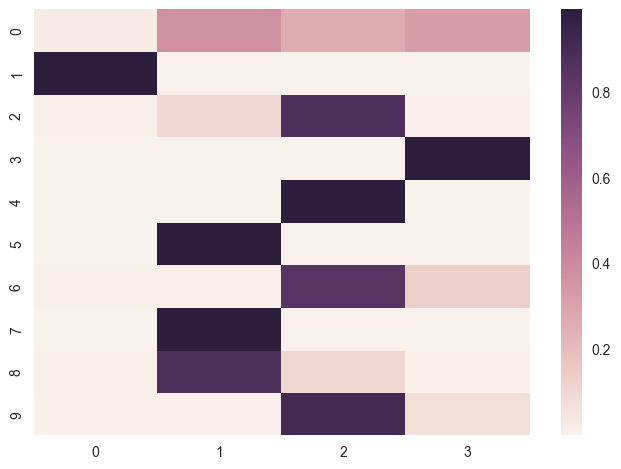

In [36]:
ax = sns.heatmap(posterior[:10,])
plt.show()

sample_posterior_over_accuracy() allows drawing samples from the posterior of the accuracy parameters. We can use such samples to draw credible intervals.

In [18]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
print samples.mean(axis=0)
print samples.std(axis=0)

[ 0.78486153  0.72992339  0.7678656   0.72045591  0.72515509  0.71087139
  0.75284506  0.70724238]
[ 0.03222878  0.03246616  0.03553917  0.03587337  0.03014607  0.03400005
  0.03373689  0.03549654]


Let's try everything again with ModelBt

In [28]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.86712456  0.78330347  0.80018607  0.70210773  0.69683119  0.83830997
  0.76970012  0.63558643]
-2850.12811001


In [29]:
model.map(anno.annotations)
print model.theta
print (model.log_likelihood(anno.annotations))

[ 0.79125916  0.74073925  0.76237961  0.72530107  0.71661308  0.71842206
  0.77323764  0.71655267]
-2811.94646526


In [30]:
posterior = model.infer_labels(anno.annotations)
print posterior

[[ 0.01109838  0.28904363  0.36504346  0.33481454]
 [ 0.99022448  0.00241721  0.00405021  0.0033081 ]
 [ 0.00249864  0.05507876  0.93459118  0.00783141]
 ..., 
 [ 0.00252817  0.04391117  0.94563669  0.00792397]
 [ 0.00249314  0.00570977  0.93253454  0.05926254]
 [ 0.03189409  0.93878692  0.01613796  0.01318103]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

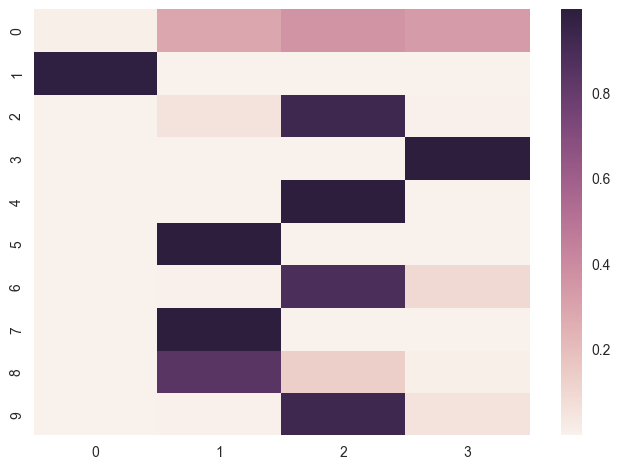

In [31]:
ax = sns.heatmap(posterior[:10,])
plt.show()

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [37]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[2, 2, 3],
       [2, 2, 3],
       [2, 2, 2],
       [0, 0, 3],
       [2, 2, 1],
       [2, 2, 2],
       [0, 0, 3],
       [0, 0, 2],
       [2, 2, 1],
       [2, 2, 1],
       [0, 2, 0],
       [2, 2, 2],
       [2, 2, 2],
       [0, 0, 2],
       [2, 3, 3],
       [0, 0, 0],
       [2, 2, 2],
       [3, 3, 2],
       [0, 0, 2],
       [2, 0, 1]])

# Visualization

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipyton notebook. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [38]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

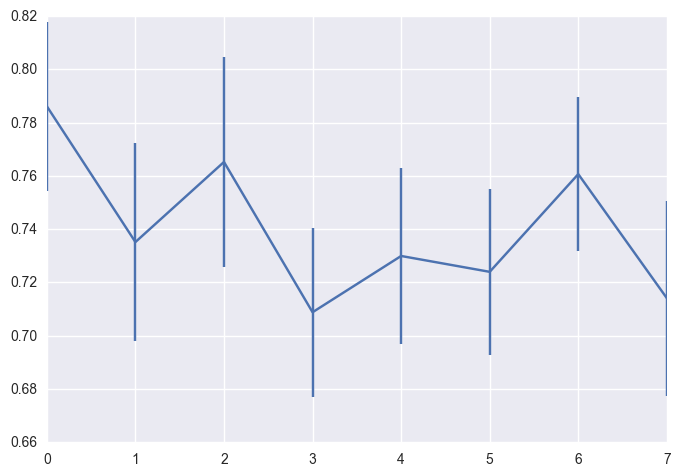

In [39]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Examples from the GSS Study.

Getting the data for each GSS question.

In [40]:
from pyanno.annotations import AnnotationsContainer
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

Let's examine the data structure.

In [41]:
dev.shape

(21461L, 6L)

In [42]:
anno_dv.labels

[0, 1]

In [43]:
anno_dv.missing_values

[-1]

In [44]:
anno_dv.annotations.shape

(21461L, 6L)

Measure agreement between coders.

In [47]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[ 1.          0.62426874  0.46682841  0.44599604  0.16569888  0.36657805]
 [ 0.62426874  1.          0.53480937  0.52673854  0.3306905   0.59513211]
 [ 0.46682841  0.53480937  1.          0.50580068  0.42393752  0.49833997]
 [ 0.44599604  0.52673854  0.50580068  1.          0.46517493  0.47023754]
 [ 0.16569888  0.3306905   0.42393752  0.46517493  1.          0.66190749]
 [ 0.36657805  0.59513211  0.49833997  0.47023754  0.66190749  1.        ]]


Visualization

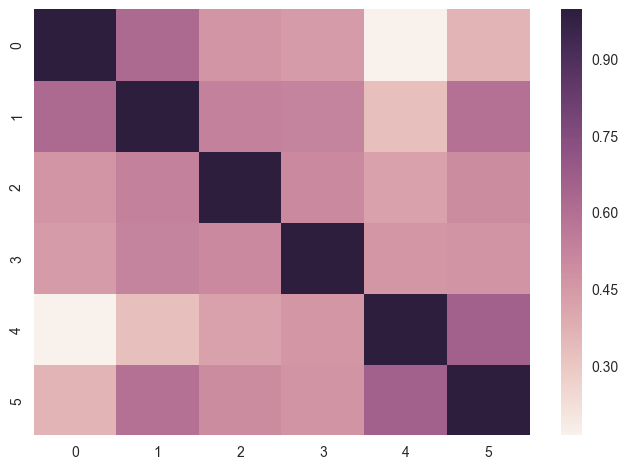

In [48]:
ax = sns.heatmap(m)
plt.show()

Let's compute the statistics on each of the dataset and also try computing the pearsons r. 

In [67]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

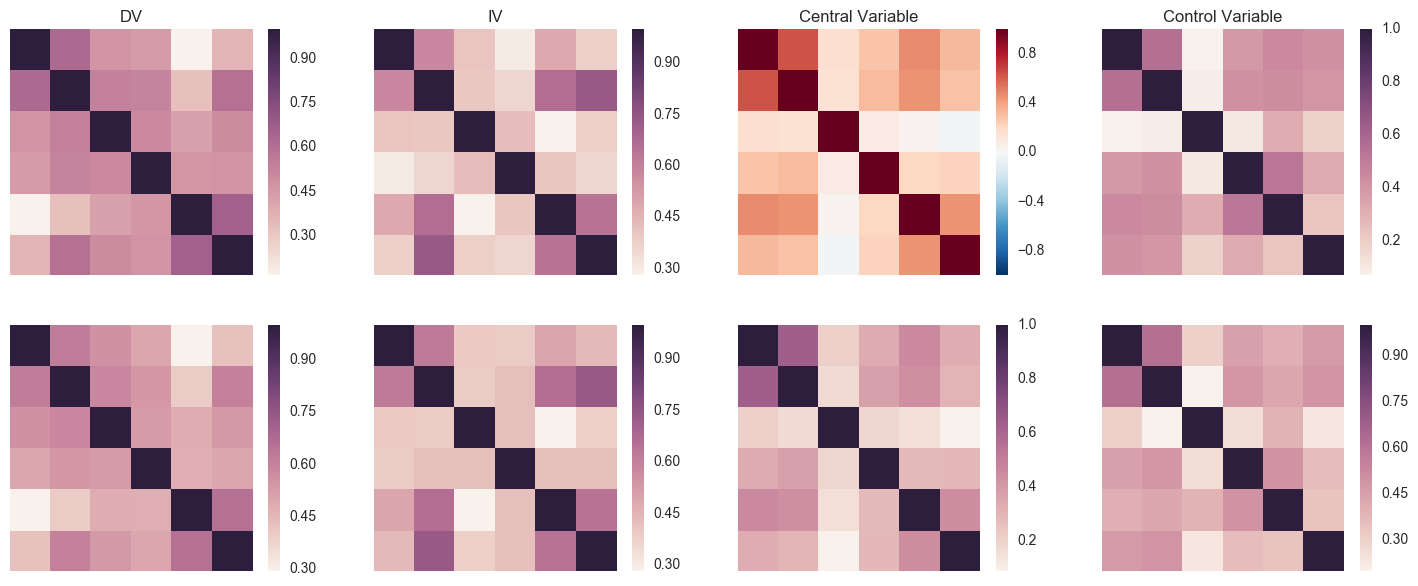

In [68]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    sns.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    sns.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Test the comparison of students

In [69]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [72]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print np.average(xdevck, weights=nondiag)
print np.average(xdevpr, weights=nondiag)
print np.average(xindck, weights=nondiag)
print np.average(xindpr, weights=nondiag)
print np.average(xcenck, weights=nondiag)
print np.average(xcenpr, weights=nondiag)
print np.average(xconck, weights=nondiag)
print np.average(xconpr, weights=nondiag)

0.472142584454
0.514240727822
0.45296278237
0.475965268669
0.270823768698
0.315140498284
0.328334778759
0.39458527792


Bring in merge data: author_dependent, mode_dependent, author_independent, mode_independent, author_central, mode_central, author_control, mode_control, author_don't_know, mode_don't_know

In [73]:
mergedata = np.loadtxt(fname="gss_mergedataC.txt", dtype=int, delimiter="\t")

In [74]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [76]:
print "Dependent variable"
print cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1])
print pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1])

print "Independent variable"
print cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1])
print pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1])

print "Central variable"
print cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1])
print pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1])

print "Control variable"
print cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1])
print pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1])

Dependent variable
0.374431105795
0.385634372036
Independent variable
0.543069016464
0.552997494177
Central variable
-0.0640171895485
-0.0888764431926
Control variable
0.281517249918
0.282392375746


Now for the assessment of the relative values of authors, then student coders.

In [77]:
print "Dependent"
print np.average(anno_merge_dep.annotations[:,0])
print np.average(anno_merge_dep.annotations[:,1])

print "Independent"
print np.average(anno_merge_ind.annotations[:,0])
print np.average(anno_merge_ind.annotations[:,1])

print "Central"
print np.average(anno_merge_cen.annotations[:,0])
print np.average(anno_merge_cen.annotations[:,1])

print "Control"
print np.average(anno_merge_con.annotations[:,0])
print np.average(anno_merge_con.annotations[:,1])

Dependent
0.476391231029
0.358347386172
Independent
0.237774030354
0.313659359191
Central
0.35328836425
0.751264755481
Control
0.0817875210793
0.0944350758853


Hacking the Model A (by adding two blank columns)

In [85]:
dev.shape

(21461L, 6L)

In [86]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [88]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([ 0.82412953,  0.92843977,  0.91771253,  0.77882657,  0.63058696,
        0.65156826,  0.65080764,  0.76395944])

In [89]:
model_devA.map(anno_dvA.annotations)

PyannoValueError: Annotations are incompatible with model parameters